<a href="https://colab.research.google.com/github/VictorHugoMartins/israel_x_palestine_data_analysis/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimentos com Modelos de Toxicidade

In [4]:
import numpy as np
import pandas as pd

from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/red_pill_analises/data_base/dados_anotados/'

def stratified_sample(df, bins=10, samples_per_bin=25, seed=42):
    # Cria faixas de toxicidade
    df['tox_bin'] = pd.cut(
        df['detoxify_toxicity'],
        bins=np.linspace(0, 1, bins + 1),
        labels=False,
        include_lowest=True
    )

    # Amostragem estratificada
    sampled = df.groupby('tox_bin', group_keys=False).apply(
        lambda g: g.sample(n=min(len(g), samples_per_bin), random_state=seed)
    ).reset_index(drop=True)

    # Embaralha os resultados
    sampled = sampled.sample(frac=1, random_state=seed).reset_index(drop=True)
    return sampled

def save_annotation_csv(sampled_df, filename='videos_anotados_pelo_detoxify.csv'):
    sampled_df[['text', 'detoxify_toxicity']].to_csv(filename, index=False)

def save_to_annotate_csv(sampled_df, filename='videos_para_classificar.csv'):
    sampled_df['misogino'] = ''
    sampled_df = sampled_df.rename({'detoxify_toxicity': 'toxico'})
    sampled_df['toxico'] = ''
    sampled_df[['text', 'misogino', 'toxico']].to_csv(filename, index=False)

# 2. Faça a amostragem
# df_comentarios = pd.read_csv(folder_path)
# sampled = stratified_sample(df_comentarios)

# # 3. Gere CSV para anotação
# save_annotation_csv(sampled)
# save_to_annotate_csv(sampled)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install transformers

In [6]:
!pip install detoxify pandas torch

In [7]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121  # Use 'cpu' se não for usar GPU

Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/

In [8]:
!pip install scikit-learn

In [9]:
!pip install torch

In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def plot_ground_truth_por_classe(df_merged, tox_score, label_cols):
  df_merged['label_final'] = df_merged[label_cols].mode(axis=1)[0]
  print(df_merged['label_final'].value_counts())

  return df_merged

In [58]:
import pandas as pd

def ler_df(folder_path):
  df_videos = pd.read_csv(folder_path)
  print("temos quantos videos? ", len(df_videos))
  return df_videos

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def tabela_anotacao_por_faixa(df_merged, tox_score, min_val=None, max_val=None, n_bins=5):
    tox_score = tox_score.strip()

    # 1. Resolver colunas duplicadas
    col_mask = [col == tox_score for col in df_merged.columns]
    col_indices = [i for i, x in enumerate(col_mask) if x]

    if len(col_indices) > 1:
        print(f"Coluna duplicada detectada: '{tox_score}' aparece {len(col_indices)} vezes")
        null_counts = [df_merged.iloc[:, i].isnull().sum() for i in col_indices]
        best_index = col_indices[np.argmin(null_counts)]
        for i in reversed(col_indices):
            if i != best_index:
                df_merged.drop(columns=df_merged.columns[i], inplace=True)
        print(f"Coluna '{tox_score}' mantida na posição {best_index} com menos nulos")

    if tox_score not in df_merged.columns:
        df_merged['tox_sexism_score'] = df_merged['tox_sexism_pred']
        tox_score = 'tox_sexism_score'

    # 2. Filtrar textos válidos
    df_valid = df_merged[df_merged[tox_score].notnull()].copy()

    # 3. Ordenar pelo score
    df_valid = df_valid.sort_values(by=tox_score).reset_index(drop=True)

    total_textos = len(df_valid)
    textos_por_faixa = total_textos // n_bins
    total_utilizavel = textos_por_faixa * n_bins
    df_uniforme = df_valid.iloc[:total_utilizavel].copy()

    # 4. Gerar rótulos de intervalo (bins) com base nos scores
    min_score = df_uniforme[tox_score].min() if min_val is None else min_val
    max_score = df_uniforme[tox_score].max() if max_val is None else max_val
    bins = np.linspace(min_score, max_score, n_bins + 1)
    faixa_labels = [f'{round(bins[i], 2)}-{round(bins[i+1], 2)}' for i in range(len(bins)-1)]

    # 5. Atribuir rótulos com base no índice (não pelo valor do score!)
    faixa_indices = np.repeat(faixa_labels, textos_por_faixa)
    df_uniforme["toxicity_range"] = faixa_indices

    # 6. Agrupar por faixa e contar os labels finais
    result = df_uniforme.groupby(['toxicity_range', 'label_final']).size().unstack(fill_value=0)

    print("Anotação baseada na Moda")
    print(result)

    # 7. Plotar as matrizes de confusão por faixa
    if 'label_final' in df_uniforme.columns and 'label_pred' in df_uniforme.columns:
        confusao_long = df_uniforme.groupby(['toxicity_range', 'label_final', 'label_pred']).size().reset_index(name='count')
        confusao_long = confusao_long.rename(columns={'label_final': 'true', 'label_pred': 'pred'})

        faixa_order = sorted(df_uniforme['toxicity_range'].unique(), key=lambda x: float(str(x).split('-')[0]))
        num_faixas = len(faixa_order)

        ncols = 5
        nrows = (num_faixas + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), constrained_layout=True)
        axes = axes.flatten()

        for i, faixa in enumerate(faixa_order):
            df_faixa = confusao_long[confusao_long['toxicity_range'] == faixa]
            pivot_df = df_faixa.pivot(index='true', columns='pred', values='count').fillna(0)

            ax = axes[i]
            sns.heatmap(pivot_df, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Matriz de Confusão\nFaixa {faixa}')
            ax.set_xlabel('Predito')
            ax.set_ylabel('Real')

        for j in range(num_faixas, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle("Matriz de Confusão por Faixa", fontsize=18)
        plt.show()

    return result


In [60]:
import seaborn as sns
import pandas as pd
import numpy as np

def plot_all_confusion_matrices_in_grid(df_cm_long, thresholds, title):
    """
    Plota 10 matrizes de confusão em uma única figura em uma grade de 2x5.

    Args:
        df_cm_long (pd.DataFrame): DataFrame com colunas 'threshold', 'true', 'pred' e 'value_abs'.
        thresholds (list or np.array): A lista de thresholds a serem plotados.
        title (str): Título principal do gráfico.
    """
    # Cria a figura e a grade de subplots
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    axes = axes.flatten()  # Acha os eixos para iterar facilmente

    # Itera sobre cada threshold e plota uma matriz em um subplot
    for idx, t in enumerate(thresholds):
        ax = axes[idx]

        # Filtra o DataFrame para o threshold atual
        df_filtered = df_cm_long[df_cm_long['threshold'] == t]

        if df_filtered.empty:
            print(f"Nenhum dado encontrado para o threshold {t}")
            continue

        # Transforma para o formato de matriz
        cm_matrix = df_filtered.pivot(index='true', columns='pred', values='value_abs')

        # Plota o heatmap no subplot atual
        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Previsto 0', 'Previsto 1'],
                    yticklabels=['Real 0', 'Real 1'], ax=ax)

        ax.set_title(f'Threshold: {t:.1f}')
        ax.set_xlabel('Classe Prevista')
        ax.set_ylabel('Classe Real')

    # Configura o título principal e o layout
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para evitar sobreposição do título
    plt.show()

In [61]:
def bootstrap_metrics(df, tox_score, threshold, label_cols, n_boot=300):
    boot_f1_0, boot_f1_1 = [], []
    boot_pre_0, boot_pre_1 = [], []
    boot_rec_0, boot_rec_1 = [], []

    boot_f1_macro = []
    boot_precision_macro = []
    boot_recall_macro = []

    for _ in range(n_boot):
        df_b = df.sample(frac=1.0, replace=True)

        df_b['label_final'] = df_b[label_cols].mode(axis=1)[0].astype(int)
        df_b['predicted'] = (df_b[tox_score] > threshold).astype(int)

        f1 = f1_score(df_b['label_final'], df_b['predicted'], average=None, labels=[0,1], zero_division=0)
        pre = precision_score(df_b['label_final'], df_b['predicted'], average=None, labels=[0,1], zero_division=0)
        rec = recall_score(df_b['label_final'], df_b['predicted'], average=None, labels=[0,1], zero_division=0)

        # guardar por classe
        boot_f1_0.append(f1[0]);  boot_f1_1.append(f1[1])
        boot_pre_0.append(pre[0]); boot_pre_1.append(pre[1])
        boot_rec_0.append(rec[0]); boot_rec_1.append(rec[1])

        # guardar macro
        boot_f1_macro.append(np.mean(f1))
        boot_precision_macro.append(np.mean(pre))
        boot_recall_macro.append(np.mean(rec))

    def ci(x):
        return np.percentile(x, [2.5, 97.5]).tolist()

    return {
        'f1': {
            '0': ci(boot_f1_0),
            '1': ci(boot_f1_1),
            'macro': ci(boot_f1_macro)
        },
        'precision': {
            '0': ci(boot_pre_0),
            '1': ci(boot_pre_1),
            'macro': ci(boot_precision_macro)
        },
        'recall': {
            '0': ci(boot_rec_0),
            '1': ci(boot_rec_1),
            'macro': ci(boot_recall_macro)
        }
    }


In [62]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def threshold_experiment_and_classify(
    df,
    label_cols,
    tox_score='toxicity',
    do_plots=True
):
    # Garantir numérico
    df[tox_score] = pd.to_numeric(df[tox_score], errors='coerce')

    thresholds = np.linspace(0.1, 1.0, 10)

    # Listas para as métricas macro (média entre classes)
    f1s_macro, precisions_macro, recalls_macro = [], [], []

    # Listas para as métricas por classe
    f1s_per_class = {'0': [], '1': []}
    prec_per_class = {'0': [], '1': []}
    rec_per_class = {'0': [], '1': []}

    # Matrizes de confusão por threshold (absolutas e normalizadas)
    conf_matrices_abs = []
    conf_matrices_norm = []

    # 1) Label final por maioria entre anotadores
    df['label_final'] = df[label_cols].mode(axis=1)[0].astype(int)

    cis_f1_0 = []
    cis_f1_1 = []
    cis_pre_0 = []
    cis_pre_1 = []
    cis_rec_0 = []
    cis_rec_1 = []

    # 2) Varre thresholds
    for t in thresholds:
        df['predicted'] = (df[tox_score] > t).astype(int)

        # average=None -> por classe; labels=[0,1] para ordem estável
        f1 = f1_score(df['label_final'], df['predicted'], average=None, labels=[0,1], zero_division=0)
        pre = precision_score(df['label_final'], df['predicted'], average=None, labels=[0,1], zero_division=0)
        rec = recall_score(df['label_final'], df['predicted'], average=None, labels=[0,1], zero_division=0)

        # Guarda macro (média simples entre classes)
        f1s_macro.append(np.mean(f1))
        precisions_macro.append(np.mean(pre))
        recalls_macro.append(np.mean(rec))

        # Guarda por classe
        f1s_per_class['0'].append(float(f1[0]));  f1s_per_class['1'].append(float(f1[1]))
        prec_per_class['0'].append(float(pre[0])); prec_per_class['1'].append(float(pre[1]))
        rec_per_class['0'].append(float(rec[0]));  rec_per_class['1'].append(float(rec[1]))

        # Matrizes de confusão
        cm_abs = confusion_matrix(df['label_final'], df['predicted'], labels=[0,1])
        cm_norm = confusion_matrix(df['label_final'], df['predicted'], labels=[0,1], normalize='true')
        conf_matrices_abs.append(cm_abs)
        conf_matrices_norm.append(cm_norm)

        ic = bootstrap_metrics(df, tox_score, t, label_cols)

        cis_f1_0.append(ic['f1']['0'])
        cis_f1_1.append(ic['f1']['1'])
        cis_pre_0.append(ic['precision']['0'])
        cis_pre_1.append(ic['precision']['1'])
        cis_rec_0.append(ic['recall']['0'])
        cis_rec_1.append(ic['recall']['1'])

    # ======= DataFrames requisitados =======
    # (1) F1 por classe vs threshold (wide)
    df_f1_por_classe = pd.DataFrame({
        'threshold': thresholds,
        'f1_class_0': f1s_per_class['0'],
        'f1_class_1': f1s_per_class['1']
    })

    # (2) Precision por classe vs threshold (wide)
    df_precision_por_classe = pd.DataFrame({
        'threshold': thresholds,
        'precision_class_0': prec_per_class['0'],
        'precision_class_1': prec_per_class['1']
    })

    # (3) Recall por classe vs threshold (wide)
    df_recall_por_classe = pd.DataFrame({
        'threshold': thresholds,
        'recall_class_0': rec_per_class['0'],
        'recall_class_1': rec_per_class['1']
    })

    df_confidence_intervals = {
      'f1_ci': pd.DataFrame({
          'threshold': thresholds,
          'ci_f1_class_0': cis_f1_0,
          'ci_f1_class_1': cis_f1_1
      }),
      'precision_ci': pd.DataFrame({
          'threshold': thresholds,
          'ci_precision_class_0': cis_pre_0,
          'ci_precision_class_1': cis_pre_1
      }),
      'recall_ci': pd.DataFrame({
          'threshold': thresholds,
          'ci_recall_class_0': cis_rec_0,
          'ci_recall_class_1': cis_rec_1
      })
    }

    # (4) Matrizes de confusão em formato longo
    def _cm_list_to_long_df(cm_list, thresholds, value_col):
        rows = []
        for idx, t in enumerate(thresholds):
            cm = cm_list[idx]
            for i, true_label in enumerate([0, 1]):
                for j, pred_label in enumerate([0, 1]):
                    rows.append({
                        'threshold': float(t),
                        'true': int(true_label),
                        'pred': int(pred_label),
                        value_col: float(cm[i, j]) if value_col != 'value_abs' else int(cm[i, j])
                    })
        return pd.DataFrame(rows)

    df_cm_abs_long = _cm_list_to_long_df(conf_matrices_abs, thresholds, value_col='value_abs')
    df_cm_norm_long = _cm_list_to_long_df(conf_matrices_norm, thresholds, value_col='value_norm')

    # (5) Melhor threshold pelo F1 macro
    best_index = int(np.argmax(f1s_macro))
    best_theta = float(thresholds[best_index])

    # (6) Classificação final com melhor threshold
    df['toxicity_classification'] = (df[tox_score] > best_theta).astype(int)

    # Adicionar a contagem por faixa de toxicidade
    bins = np.linspace(0.0, 1.0, 11)
    labels = [f'{x:.1f}-{y:.1f}' for x, y in zip(bins[:-1], bins[1:])]
    df['toxicity_range'] = pd.cut(df[tox_score], bins=bins, labels=labels, right=False, include_lowest=True)
    counts_df = df.groupby(['toxicity_range', 'toxicity_classification']).size().unstack(fill_value=0)
    counts_df.columns = [f'predicted_{col}' for col in counts_df.columns]

    # (7) Métricas finais
    final_precision = precision_score(df['label_final'], df['toxicity_classification'],
                                      average=None, labels=[0,1], zero_division=0)
    final_recall = recall_score(df['label_final'], df['toxicity_classification'],
                                     average=None, labels=[0,1], zero_division=0)
    final_f1 = f1_score(df['label_final'], df['toxicity_classification'],
                                average=None, labels=[0,1], zero_division=0)
    final_accuracy = accuracy_score(df['label_final'], df['toxicity_classification'])

    # Suportes por classe
    supports = df['label_final'].value_counts().reindex([0,1]).fillna(0).astype(int).to_dict()

    # DataFrame com métricas finais por classe
    df_final_por_classe = pd.DataFrame([
        {
            'classe': 0,
            'support': int(supports.get(0, 0)),
            'precision': float(final_precision[0]),
            'recall': float(final_recall[0]),
            'f1': float(final_f1[0]),
        },
        {
            'classe': 1,
            'support': int(supports.get(1, 0)),
            'precision': float(final_precision[1]),
            'recall': float(final_recall[1]),
            'f1': float(final_f1[1]),
        }
    ])

    metrics = {
        'best_threshold': best_theta,
        'thresholds': thresholds.tolist(),
        'threshold_curves': {
            'macro': {
                'f1': f1s_macro,
                'precision': precisions_macro,
                'recall': recalls_macro
            },
            'per_class': {
                '0': {
                    'f1': f1s_per_class['0'],
                    'precision': prec_per_class['0'],
                    'recall': rec_per_class['0']
                },
                '1': {
                    'f1': f1s_per_class['1'],
                    'precision': prec_per_class['1'],
                    'recall': rec_per_class['1']
                }
            },
            'confusion_matrices': {
                'absolute': [cm.tolist() for cm in conf_matrices_abs],
                'normalized': [cm.tolist() for cm in conf_matrices_norm]
            }
        },
        'final': {
            'accuracy': float(final_accuracy),
            'per_class': {
                '0': {
                    'support': int(supports.get(0, 0)),
                    'precision': float(final_precision[0]),
                    'recall': float(final_recall[0]),
                    'f1': float(final_f1[0]),
                },
                '1': {
                    'support': int(supports.get(1, 0)),
                    'precision': float(final_precision[1]),
                    'recall': float(final_recall[1]),
                    'f1': float(final_f1[1]),
                }
            }
        }
    }

    # Limpeza da coluna auxiliar
    df.drop(columns=['predicted'], errors='ignore', inplace=True)

    # Pacote de DataFrames para retornar
    dataframes = {
        'f1_por_classe_wide': df_f1_por_classe,
        'precision_por_classe_wide': df_precision_por_classe,
        'recall_por_classe_wide': df_recall_por_classe,
        'confusao_abs_long': df_cm_abs_long,
        'confusao_norm_long': df_cm_norm_long,
        'final_por_classe': df_final_por_classe
    }

    return df, metrics, dataframes, df_confidence_intervals

# Detoxify

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def plot_toxicity_cdf(df, column):
    # 1. Pega a coluna de toxicidade de todos os vídeos
    toxicity_scores = df[column].dropna().values

    # 2. Ordena os valores em ordem crescente (essencial para CDF)
    sorted_scores = np.sort(toxicity_scores)

    # 3. Cria os valores acumulados (proporção)
    cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)

    # 4. Cria o gráfico
    plt.figure(figsize=(6, 3))
    plt.plot(sorted_scores, cdf, color='darkred', lw=2, label='CDF')

    # 5. Adiciona linha vertical no ponto 0.7
    plt.axvline(x=0.7, color='gray', linestyle='--', lw=1)
    plt.text(0.7, 0.05, '0.7', ha='center', fontsize=8)

    # 6. Calcula e mostra % de vídeos com toxicidade > 0.7
    perc_above = np.sum(toxicity_scores > 0.7) / len(toxicity_scores) * 100
    plt.text(0.72, 0.6, f'{perc_above:.1f}% > 0.7', color='black', fontsize=9)

    # 7. Formatações finais
    plt.xlabel(column)
    plt.ylabel("Proporção Acumulada (CDF)")
    plt.grid(False)
    plt.ylim(0, 1.01)
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()


In [64]:
import numpy as np
import pandas as pd

def experimento(df_merged, algoritmo, tox_cols, tox_score, min_val, max_val, n_bins, label1, label2, label3):
    print("Ground truth por classe -----------------------------------------")
    df_merged = plot_ground_truth_por_classe(df_merged, tox_score, label_cols=[label1, label2, label3])
    print("Anotações por classe por faixa -----------------------------------------")
    result = tabela_anotacao_por_faixa(df_merged, tox_score, min_val, max_val, n_bins)
    df_final, metrics, dfs, df_coms_intervalo_de_confianca = threshold_experiment_and_classify(
        df_merged,
        label_cols=[label1, label2, label3],
        tox_score=tox_score,
        do_plots=False
    )

    # Métricas finais por classe
    final_cls0 = metrics['final']['per_class']['0']
    final_cls1 = metrics['final']['per_class']['1']

    print(df_coms_intervalo_de_confianca)

    # Cálculo do Macro F1
    macro_f1 = (final_cls0['f1'] + final_cls1['f1']) / 2

    print("Melhor theta:", metrics['best_threshold'])
    print(f"Macro F1 final: {macro_f1:.4f}")

    print("\n=== F1 por classe (wide) ===")
    print(dfs['f1_por_classe_wide'].to_string(index=False))

    print("\n=== Precision por classe (wide) ===")
    print(dfs['precision_por_classe_wide'].to_string(index=False))

    print("\n=== Recall por classe (wide) ===")
    print(dfs['recall_por_classe_wide'].to_string(index=False))

    print("\n=== Matriz de confusão (absoluta) ===")
    df_cm_abs_long = dfs['confusao_abs_long']

    thresholds_list = np.linspace(0.1, 1.0, 10)
    plot_all_confusion_matrices_in_grid(
        df_cm_long=df_cm_abs_long,
        thresholds=thresholds_list,
        title='Matrizes de Confusão Absoluta por Threshold'
    )

    print("\n=== Métricas finais por classe ===")
    print(dfs['final_por_classe'].to_string(index=False))

    df_merged.to_csv(folder_path + f'classificados_{algoritmo}_apos_tunning.csv', index=False)


## Detoxify Misoginia

In [65]:
import pandas as pd
from detoxify import Detoxify
from tqdm import tqdm

# Certifique-se de que seu DataFrame possui a coluna 'text'
# Exemplo: df_videos = pd.DataFrame({'text': ["Você é incrível", "Seu idiota nojento!"]})

# Carrega o modelo adequado para múltiplos idiomas
model = Detoxify('multilingual')

# Função para aplicar a análise linha a linha
def analyze_toxicity_detoxify(texts):
    results = []
    for text in tqdm(texts, desc="Analisando toxicidade"):
        try:
            scores = model.predict(text)
        except Exception:
            # Se ocorrer erro, retorna pontuações nulas
            scores = {k: None for k in model.predict("teste").keys()}
        results.append(scores)
    return results

In [66]:
from detoxify import Detoxify
import pandas as pd

def classificar_com_detoxify(df_para_classificar: pd.DataFrame, df_scores_detoxify: pd.DataFrame) -> pd.DataFrame:
    RESP_COL = "text"
    DETOX_PREFIX = "detoxify_"

    # ===== Selecionar colunas de interesse nos scores salvos =====
    detox_cols = [col for col in df_scores_detoxify.columns if col.startswith(DETOX_PREFIX)]
    cols_para_merge = [RESP_COL] + detox_cols

    # ===== Remover duplicatas nos textos de scores salvos =====
    df_scores_unicos = df_scores_detoxify[cols_para_merge].drop_duplicates(subset=[RESP_COL])

    # ===== Fazer merge para adicionar os scores existentes =====
    df_classificado = df_para_classificar.merge(
        df_scores_unicos,
        on=RESP_COL,
        how='left'
    )

    # ===== Identificar textos ainda não classificados =====
    df_nao_classificados = df_classificado[
        df_classificado[f"{DETOX_PREFIX}toxicity"].isnull() & df_classificado[RESP_COL].notnull()
    ]

    print(f"Textos novos para classificar: {len(df_nao_classificados)}")

    # ===== Classificar os textos restantes =====
    if not df_nao_classificados.empty:
        model = Detoxify('multilingual')
        textos_novos = df_nao_classificados[RESP_COL].tolist()
        resultados = model.predict(textos_novos)

        # ===== Atribuir os resultados aos índices corretos =====
        idxs_para_preencher = df_classificado[
            df_classificado[f"{DETOX_PREFIX}toxicity"].isnull()
        ].index

        for key in resultados:
            col_name = f"{DETOX_PREFIX}{key}"
            df_classificado.loc[idxs_para_preencher, col_name] = resultados[key]

    return df_classificado


In [67]:
import numpy as np
import pandas as pd

from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/red_pill_analises/data_base/'

tox_score = 'toxicity'

print("Lendo anotações -----------------------------------------")
df_ground_truth = pd.read_excel(folder_path + 'dados_anotados/experimento_comentarios.xlsx')

print("Lendo scores previamente calculados ----------------------")
df_scores_detoxify = pd.read_csv(folder_path + 'resultados/comentarios_com_scores_de_toxicidade.csv')

tox_cols = ['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
algoritmo = 'videos_com_detoxify'


print("Classsificando textos -------------------------------------")
df_anotado = classificar_com_detoxify(df_ground_truth, df_scores_detoxify)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lendo anotações -----------------------------------------
Lendo scores previamente calculados ----------------------
Classsificando textos -------------------------------------
Textos novos para classificar: 4


In [68]:
df_anotado.to_csv(folder_path + 'scores_detoxify_atualizado_comments.csv')

Index(['Unnamed: 0', 'text', 'misogino1', 'toxico1', 'misogino2', 'toxico2',
       'misogino3', 'toxico3', 'detoxify_toxicity', 'detoxify_severe_toxicity',
       'detoxify_obscene', 'detoxify_identity_attack', 'detoxify_insult',
       'detoxify_threat', 'detoxify_sexual_explicit'],
      dtype='object')
Index(['text', 'misogino1', 'toxico1', 'misogino2', 'toxico2', 'misogino3',
       'toxico3'],
      dtype='object')
Index(['Unnamed: 0', 'text', 'misogino1', 'toxico1', 'misogino2', 'toxico2',
       'misogino3', 'toxico3', 'detoxify_toxicity', 'detoxify_severe_toxicity',
       'detoxify_obscene', 'detoxify_identity_attack', 'detoxify_insult',
       'detoxify_threat', 'detoxify_sexual_explicit', 'is_offensive'],
      dtype='object')
Ground truth por classe -----------------------------------------
label_final
0    153
1     97
Name: count, dtype: int64
Anotações por classe por faixa -----------------------------------------
Anotação baseada na Moda
label_final      0   1
toxicity

/tmp/ipython-input-4222686020.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_df = df.groupby(['toxicity_range', 'toxicity_classification']).size().unstack(fill_value=0)


{'f1_ci':    threshold                              ci_f1_class_0  \
0        0.1  [0.12418981481481481, 0.2820230693717277]   
1        0.2  [0.2575009567546881, 0.41536744015333793]   
2        0.3  [0.34596513299784326, 0.4936204927394354]   
3        0.4  [0.44113997879109224, 0.6023452409351144]   
4        0.5  [0.49441479433114416, 0.6394336951944223]   
5        0.6   [0.5647282608695652, 0.6906703190460844]   
6        0.7   [0.6098633356007668, 0.7213021147287846]   
7        0.8   [0.6477139450675615, 0.7503595890410959]   
8        0.9   [0.6993136078901773, 0.7907599667774087]   
9        1.0    [0.717948717948718, 0.8009592326139089]   

                               ci_f1_class_1  
0  [0.49348586235963826, 0.6112759643916914]  
1   [0.4651467132209763, 0.6128881278538811]  
2   [0.4306817703584204, 0.5932241379310345]  
3  [0.43506302521008405, 0.5808389093342254]  
4  [0.37735849056603776, 0.5360815829918032]  
5   [0.3370765925176946, 0.5089019189765458]  
6  [0.26703

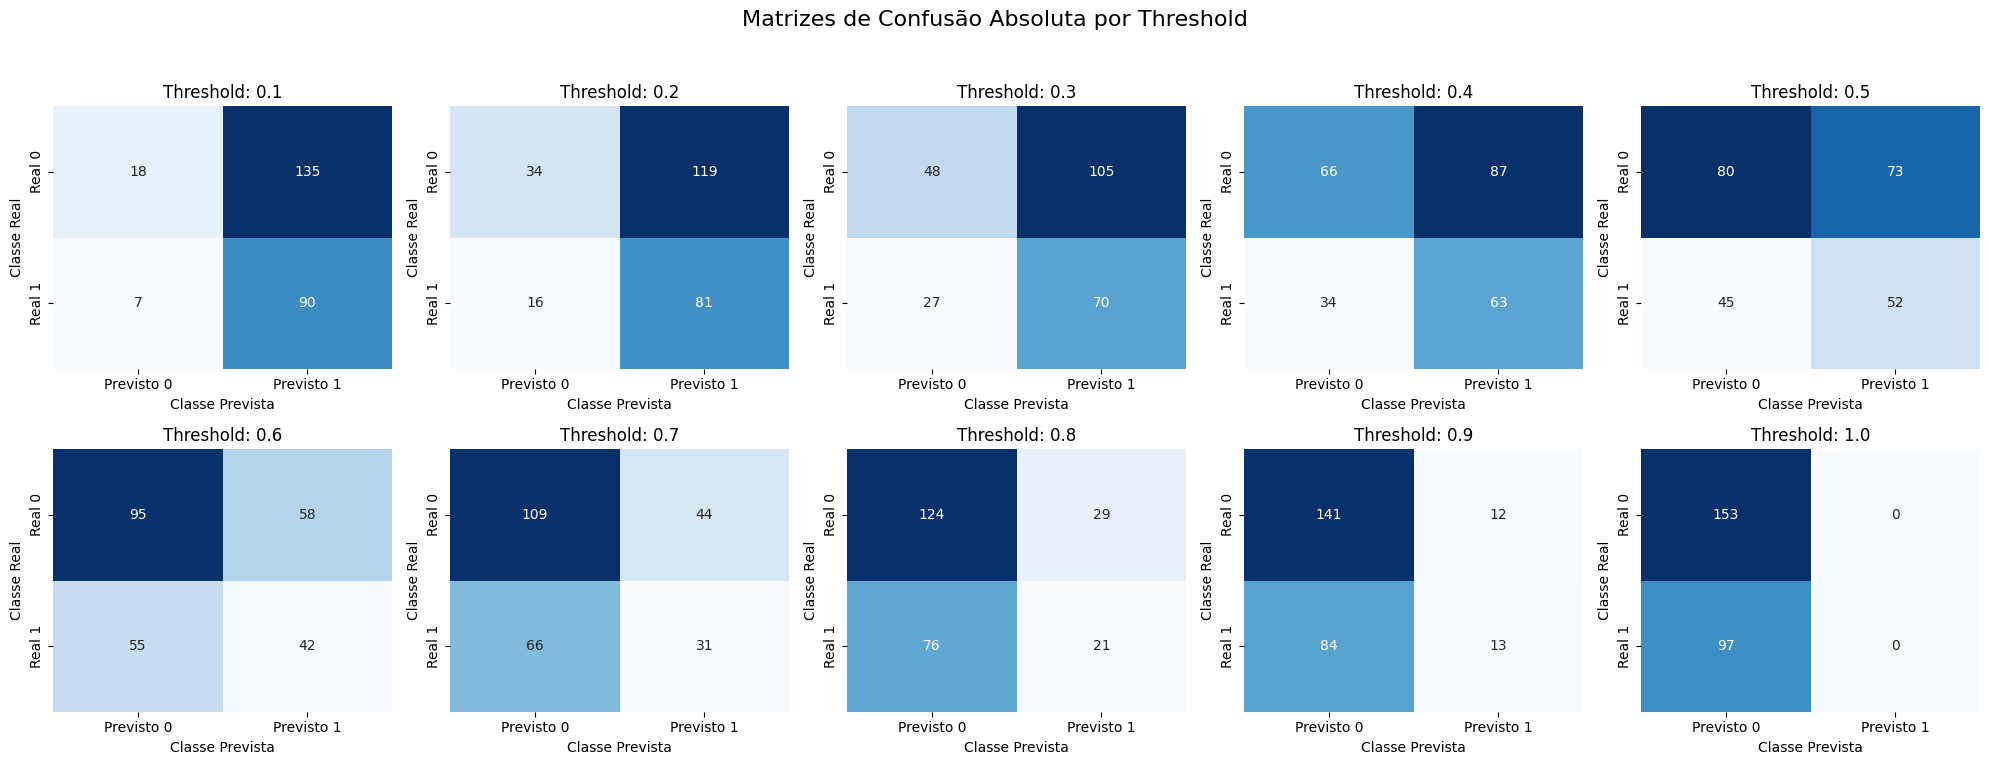


=== Métricas finais por classe ===
 classe  support  precision   recall       f1
      0      153   0.633333 0.620915 0.627063
      1       97   0.420000 0.432990 0.426396


In [69]:
df_anotado = pd.read_csv(folder_path + 'scores_detoxify_atualizado_comments.csv')

print(df_anotado.columns)
print(df_ground_truth.columns)

tox_cols = ['detoxify_toxicity']

df_anotado['is_offensive'] = (df_anotado['detoxify_toxicity'] > 0.7).astype(int)
df_anotado.head()

print(df_anotado.columns)

experimento(df_anotado, algoritmo, tox_cols, 'detoxify_toxicity', min_val=0, max_val=1, n_bins=10, label1='misogino1', label2='misogino2', label3='misogino3')

df_anotado.to_csv('anotado_detoxify_misoginia.csv')

## Detoxify para Toxicidade

Index(['Unnamed: 0', 'text', 'misogino1', 'toxico1', 'misogino2', 'toxico2',
       'misogino3', 'toxico3', 'detoxify_toxicity', 'detoxify_severe_toxicity',
       'detoxify_obscene', 'detoxify_identity_attack', 'detoxify_insult',
       'detoxify_threat', 'detoxify_sexual_explicit', 'is_offensive',
       'label_final', 'toxicity_classification', 'toxicity_range'],
      dtype='object')
Ground truth por classe -----------------------------------------
label_final
1    196
0     54
Name: count, dtype: int64
Anotações por classe por faixa -----------------------------------------
Anotação baseada na Moda
label_final      0   1
toxicity_range        
0.0-0.1         13  12
0.1-0.2          8  17
0.2-0.3          5  20
0.3-0.4          9  16
0.4-0.5          7  18
0.5-0.6          3  22
0.6-0.7          2  23
0.7-0.8          5  20
0.8-0.9          2  23
0.9-1.0          0  25


/tmp/ipython-input-4222686020.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_df = df.groupby(['toxicity_range', 'toxicity_classification']).size().unstack(fill_value=0)


{'f1_ci':    threshold                               ci_f1_class_0  \
0        0.1     [0.1917808219178082, 0.447361111111111]   
1        0.2   [0.26717032967032966, 0.5243557065986972]   
2        0.3     [0.288135593220339, 0.5018356643356643]   
3        0.4   [0.36688587406793705, 0.5465210766886743]   
4        0.5    [0.3694507536650836, 0.5474393082806783]   
5        0.6    [0.3547192258883249, 0.5190904139433551]   
6        0.7  [0.33009618687736175, 0.48333333333333334]   
7        0.8   [0.32983103159656835, 0.4888946819603754]   
8        0.9  [0.31797151457308565, 0.46103621464446204]   
9        1.0    [0.2876712328767123, 0.4227129337539432]   

                                ci_f1_class_1  
0    [0.8407768252297979, 0.9066492475361331]  
1    [0.8025623885918003, 0.8805324162223914]  
2    [0.7437283203352345, 0.8331164383561644]  
3    [0.7051448639157155, 0.8061367143416476]  
4    [0.6416109192921882, 0.7612813109845751]  
5    [0.5534013104616065, 0.6688772376272

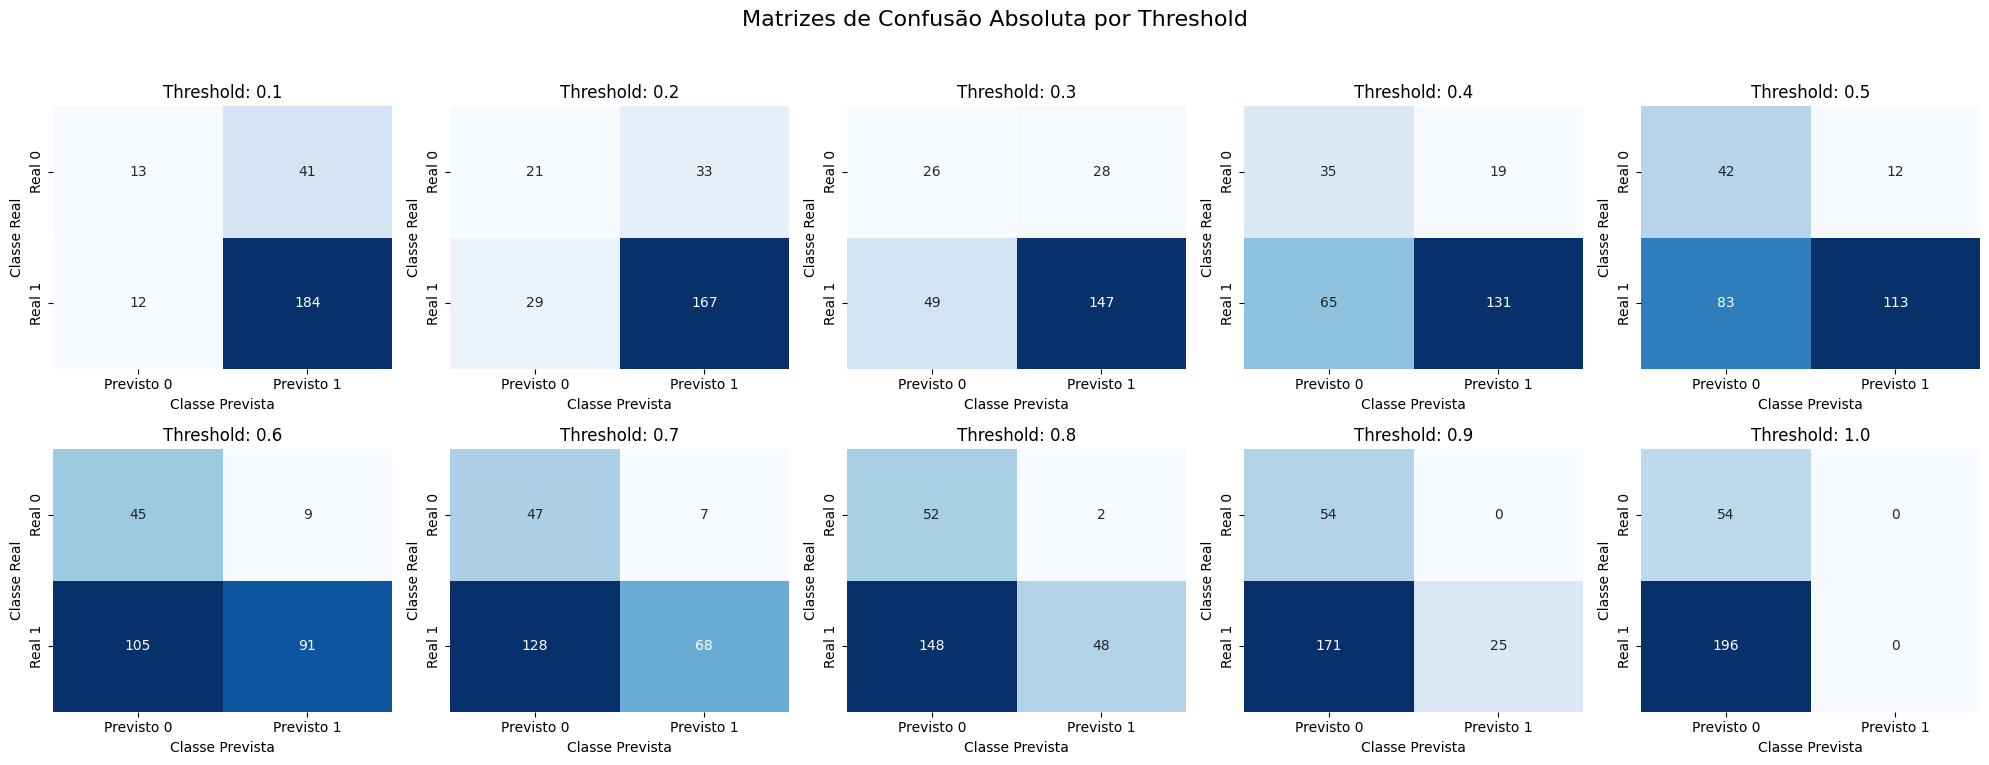


=== Métricas finais por classe ===
 classe  support  precision   recall       f1
      0       54      0.420 0.388889 0.403846
      1      196      0.835 0.852041 0.843434


In [70]:
tox_cols = ['detoxify_toxicity', 'detoxify_severe_toxicity', 'detoxify_obscene', 'detoxify_identity_attack', 'detoxify_insult', 'detoxify_threat']

df_anotado['is_offensive'] = (df_anotado[tox_cols] >= 0.7).any(axis=1).astype(int)
df_anotado.head()

print(df_anotado.columns)

experimento(df_anotado, algoritmo, tox_cols, 'detoxify_toxicity', min_val=0, max_val=1, n_bins=10, label1='toxico1', label2='toxico2', label3='toxico3')

df_anotado.to_csv('anotado_detoxify_misoginia.csv')

In [71]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa

# Preencher NaNs com 0
df_ground_truth[['misogino1', 'misogino2', 'misogino3']] = df_ground_truth[['misogino1', 'misogino2', 'misogino3']].fillna(0)

# ===== Cálculo do Kappa de Cohen entre pares =====
kappa_1_2 = cohen_kappa_score(df_ground_truth['misogino1'], df_ground_truth['misogino2'])
kappa_1_3 = cohen_kappa_score(df_ground_truth['misogino1'], df_ground_truth['misogino3'])
kappa_2_3 = cohen_kappa_score(df_ground_truth['misogino2'], df_ground_truth['misogino3'])

print("Kappa (misogino 1 vs 2):", kappa_1_2)
print("Kappa (misogino 1 vs 3):", kappa_1_3)
print("Kappa (misogino 2 vs 3):", kappa_2_3)

# ===== Cálculo do número de textos com consenso total =====
df_ground_truth['consenso_total'] = (
    (df_ground_truth['misogino1'] == df_ground_truth['misogino2']) &
    (df_ground_truth['misogino1'] == df_ground_truth['misogino3'])
)
quantidade_consenso = df_ground_truth['consenso_total'].sum()
print("Textos com consenso total:", quantidade_consenso)

# ===== Fleiss' Kappa =====
# Supondo que os rótulos possíveis sejam 0 e 1
labels = [0, 1]
matriz_contagem = []

for _, row in df_ground_truth[['misogino1', 'misogino2', 'misogino3']].iterrows():
    contagem = [list(row).count(label) for label in labels]
    matriz_contagem.append(contagem)

matriz_contagem = np.array(matriz_contagem)
fleiss = fleiss_kappa(matriz_contagem, method='fleiss')
print("Fleiss' Kappa:", fleiss)


Kappa (misogino 1 vs 2): 0.6991978609625669
Kappa (misogino 1 vs 3): 0.7144584789035205
Kappa (misogino 2 vs 3): 0.6493688639551192
Textos com consenso total: 195
Fleiss' Kappa: 0.6874431714857248


In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa

# Preencher NaNs com 0
df_ground_truth[['toxico1', 'toxico2', 'toxico3']] = df_ground_truth[['toxico1', 'toxico2', 'toxico3']].fillna(0)

# ===== Cálculo do Kappa de Cohen entre pares =====
kappa_1_2 = cohen_kappa_score(df_ground_truth['toxico1'], df_ground_truth['toxico2'])
kappa_1_3 = cohen_kappa_score(df_ground_truth['toxico1'], df_ground_truth['toxico3'])
kappa_2_3 = cohen_kappa_score(df_ground_truth['toxico2'], df_ground_truth['toxico3'])

print("Kappa (toxico 1 vs 2):", kappa_1_2)
print("Kappa (toxico 1 vs 3):", kappa_1_3)
print("Kappa (toxico 2 vs 3):", kappa_2_3)

# ===== Cálculo do número de textos com consenso total =====
df_ground_truth['consenso_total'] = (
    (df_ground_truth['toxico1'] == df_ground_truth['toxico2']) &
    (df_ground_truth['toxico1'] == df_ground_truth['toxico3'])
)
quantidade_consenso = df_ground_truth['consenso_total'].sum()
print("Textos com consenso total:", quantidade_consenso)

# ===== Fleiss' Kappa =====
# Supondo que os rótulos possíveis sejam 0 e 1
labels = [0, 1]
matriz_contagem = []

for _, row in df_ground_truth[['toxico1', 'toxico2', 'toxico3']].iterrows():
    contagem = [list(row).count(label) for label in labels]
    matriz_contagem.append(contagem)

matriz_contagem = np.array(matriz_contagem)
fleiss = fleiss_kappa(matriz_contagem, method='fleiss')
print("Fleiss' Kappa:", fleiss)


Kappa (toxico 1 vs 2): 0.5886423086659354
Kappa (toxico 1 vs 3): 0.5448085975663913
Kappa (toxico 2 vs 3): 0.46496512365250475
Textos com consenso total: 183
Fleiss' Kappa: 0.529357772387116


In [73]:
FIM

NameError: name 'FIM' is not defined

# GuardRail

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def score_toxiguardrail_prompt_fixo(
    tokenizer,
    device,
    toxiGuardrail,
    df: pd.DataFrame,
    response_col: str,
    prompt: str,
    batch_size: int = 32,
    max_length: int = 512,
) -> pd.Series:
    responses = df[response_col].fillna("").astype(str).tolist()
    prompts = [prompt] * len(responses)

    scores = []
    for i in range(0, len(responses), batch_size):
        p_batch = prompts[i:i+batch_size]
        r_batch = responses[i:i+batch_size]

        tokens = tokenizer(
            p_batch,
            r_batch,
            truncation=True,
            max_length=max_length,
            padding=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            out = toxiGuardrail(**tokens)
            logits = out.logits

        if logits.ndim == 2 and logits.shape[1] == 1:
            batch_scores = logits.squeeze(-1).detach().cpu().tolist()
        else:
            probs = torch.softmax(logits, dim=-1).detach().cpu()
            id2label = toxiGuardrail.config.id2label
            toxic_idx = None
            for k, v in id2label.items():
                name = str(v).lower()
                if any(x in name for x in ["toxic", "unsafe", "harm", "tóxic", "viol", "negat"]):
                    toxic_idx = int(k)
                    break
            if toxic_idx is None:
                toxic_idx = 1 if probs.shape[1] > 1 else 0
            batch_scores = probs[:, toxic_idx].tolist()

        scores.extend(batch_scores)

    return pd.Series(scores, index=df.index, name="guardrail_score")

def classificar_com_guardrail(df_para_classificar: pd.DataFrame, df_scores_guardrail: pd.DataFrame) -> pd.DataFrame:
    RESP_COL = "text"
    SCORE_COL = "guardrail_score"

    # ===== Selecionar colunas de interesse =====
    cols_para_merge = [RESP_COL, SCORE_COL]

    # ===== Remover duplicatas dos scores =====
    df_scores_unicos = df_scores_guardrail[cols_para_merge].drop_duplicates(subset=[RESP_COL])

    # ===== Fazer merge para adicionar os scores existentes =====
    df_classificado = df_para_classificar.merge(
        df_scores_unicos,
        on=RESP_COL,
        how='left'
    )

    # ===== Identificar textos ainda não classificados =====
    df_nao_classificados = df_classificado[
        df_classificado[SCORE_COL].isnull() & df_classificado[RESP_COL].notnull()
    ]

    print(f"Textos novos para classificar com Guardrail: {len(df_nao_classificados)}")

    # ===== Classificar os textos restantes =====
    if not df_nao_classificados.empty:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        CKPT = "nicholasKluge/ToxiGuardrailPT"
        tokenizer = AutoTokenizer.from_pretrained(CKPT)
        toxiGuardrail = AutoModelForSequenceClassification.from_pretrained(CKPT)
        toxiGuardrail.eval().to(device)

        prompt = "Classifique textos que são misóginos ou não"

        novos_scores = score_toxiguardrail_prompt_fixo(
            tokenizer,
            device,
            toxiGuardrail,
            df_nao_classificados,
            response_col=RESP_COL,
            prompt=prompt,
            batch_size=32,
            max_length=512
        )

        # ===== Atribuir os resultados aos índices corretos =====
        idxs_para_preencher = df_classificado[
            df_classificado[SCORE_COL].isnull()
        ].index

        df_classificado.loc[idxs_para_preencher, SCORE_COL] = novos_scores

    return df_classificado


## ToxiGuard para Misoginia

In [ ]:
df_anotado = classificar_com_guardrail(df_ground_truth, df_scores_detoxify)

In [ ]:
df_anotado1 = df_anotado
experimento(df_anotado1, algoritmo, tox_cols, 'guardrail_score', min_val=-6, max_val=6, n_bins=10, label1='misoginia1', label2='misoginia2', label3='misoginia3')

## ToxiGuard para Toxicidade

In [ ]:
tox_score = 'guardrail_score'
tox_cols = ['guardrail_score']

df_anotado['is_offensive'] = (df_anotado['guardrail_score'] <= -0.5).astype(int)
df_anotado.head()

experimento(df_anotado, algoritmo, tox_cols, 'guardrail_score', min_val=-6, max_val=6, n_bins=10, label1='toxico1', label2='toxico2', label3='toxico3')

df_anotado.to_csv('anotado_toxiguard_toxicidade.csv')

# Doug Trajano

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def classificar_com_dougtrajano(df_para_classificar: pd.DataFrame, df_scores_doug: pd.DataFrame) -> pd.DataFrame:
    RESP_COL = "text"  # coluna com os textos
    PREFIX = "doug_tox_"

    # ===== Selecionar colunas de interesse nos scores salvos =====
    cols_para_merge = [col for col in df_scores_doug.columns if col.startswith(PREFIX)]
    cols_para_merge = [RESP_COL] + cols_para_merge

    # ===== Remover duplicatas nos textos de scores salvos =====
    df_scores_unicos = df_scores_doug[cols_para_merge].drop_duplicates(subset=[RESP_COL])

    # ===== Fazer merge para adicionar os scores existentes =====
    df_classificado = df_para_classificar.merge(
        df_scores_unicos,
        on=RESP_COL,
        how="left"
    )

    # ===== Identificar textos ainda não classificados =====
    alguma_col_score = [col for col in df_classificado.columns if col.startswith(f"{PREFIX}") and col.endswith("_score")]
    if alguma_col_score:
        df_nao_classificados = df_classificado[df_classificado[alguma_col_score[0]].isnull() & df_classificado[RESP_COL].notnull()]
    else:
        df_nao_classificados = df_classificado[df_classificado[RESP_COL].notnull()]

    print(f"Textos novos para classificar: {len(df_nao_classificados)}")

    # ===== Classificar os textos restantes =====
    if not df_nao_classificados.empty:
        CKPT = "dougtrajano/toxicity-type-detection"
        tokenizer = AutoTokenizer.from_pretrained(CKPT)
        model = AutoModelForSequenceClassification.from_pretrained(CKPT)
        model.eval()

        # Detectar tipo de problema automaticamente (ou force se necessário)
        # model.config.problem_type = "multi_label_classification"

        def analyze_toxicity(texts: pd.Series, model, tokenizer):
            from torch.nn.functional import sigmoid, softmax

            max_pos = getattr(model.config, "max_position_embeddings", 512)
            window = max_pos - 2  # para CLS e SEP
            stride = 64
            microbatch_size = 16
            problem_type = getattr(model.config, "problem_type", None)

            id2label = model.config.id2label
            num_labels = model.config.num_labels
            labels = [id2label[i] for i in range(num_labels)]

            PAD_ID = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0

            def _chunks_by_tokens(text: str):
                enc_full = tokenizer(text, add_special_tokens=False, return_attention_mask=False)
                ids = enc_full["input_ids"]
                if len(ids) <= window:
                    return [tokenizer.build_inputs_with_special_tokens(ids)]
                chunks = []
                start = 0
                while start < len(ids):
                    end = min(start + window, len(ids))
                    chunk_ids = tokenizer.build_inputs_with_special_tokens(ids[start:end])
                    chunks.append(chunk_ids)
                    if end == len(ids):
                        break
                    start = max(0, end - stride)
                return chunks

            def _pad_batch(batch):
                max_len_batch = max(len(ids) for ids in batch)
                input_ids = []
                attn_masks = []
                for ids in batch:
                    pad_len = max_len_batch - len(ids)
                    input_ids.append(ids + [PAD_ID] * pad_len)
                    attn_masks.append([1] * len(ids) + [0] * pad_len)
                input_ids = torch.tensor(input_ids, dtype=torch.long, device=device)
                attn_masks = torch.tensor(attn_masks, dtype=torch.long, device=device)
                return input_ids, attn_masks

            def _forward_on_chunks(chunks):
                logits_list = []
                for i in range(0, len(chunks), microbatch_size):
                    batch = chunks[i:i + microbatch_size]
                    input_ids, attention_mask = _pad_batch(batch)
                    with torch.no_grad():
                        out = model(input_ids=input_ids, attention_mask=attention_mask)
                    logits_list.append(out.logits.detach().cpu())
                return torch.cat(logits_list, dim=0)

            rows = []
            for text in texts.fillna("").astype(str):
                chunks = _chunks_by_tokens(text)
                if not chunks:
                    score_vec = [0.0] * num_labels
                    bin_vec = [0] * num_labels
                else:
                    logits = _forward_on_chunks(chunks)
                    if problem_type == "multi_label_classification":
                        probs = sigmoid(logits)
                        agg = probs.max(dim=0).values
                        score_vec = agg.tolist()
                        bin_vec = [int(s >= 0.5) for s in score_vec]
                    else:
                        probs = softmax(logits, dim=-1)
                        agg = probs.mean(dim=0)
                        score_vec = agg.tolist()
                        top1 = int(torch.argmax(agg).item())
                        bin_vec = [1 if i == top1 else 0 for i in range(num_labels)]

                row = {}
                for i, label in enumerate(labels):
                    row[f"{PREFIX}{label}_score"] = float(score_vec[i])
                    row[f"{PREFIX}{label}_pred"] = int(bin_vec[i])
                rows.append(row)

            return pd.DataFrame(rows)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        novos_scores = analyze_toxicity(df_nao_classificados[RESP_COL], model, tokenizer)
        novos_scores[RESP_COL] = df_nao_classificados[RESP_COL].values

        # ===== Recombinar os resultados =====
        df_classificado = df_classificado.drop(columns=[col for col in df_classificado.columns if col.startswith(PREFIX)], errors="ignore")
        df_classificado = df_classificado.merge(novos_scores, on=RESP_COL, how="left")

    return df_classificado


## OLID BR Misoginia

In [ ]:
tox_score = 'tox_sexism_score'

print("Classificando sampled_df ---------------")
algoritmo = 'videos_com_dougtrajano'
df_anotado = classificar_com_dougtrajano(df_ground_truth, df_scores_detoxify)

In [ ]:
print("Identificando ofensivos ---------------")
print(len(df_anotado))
print(df_anotado.columns)
df_anotado['is_offensive'] = df_anotado['doug_tox_sexism_pred']

print("Identificou os textos ofensivos")
print(df_anotado.head())

#tox_cols = ['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
tox_cols = ['doug_tox_insult_score', 'doug_tox_lgbtqphobia_score',
       'doug_tox_other_lifestyle_score', 'doug_tox_physical_aspects_score',
       'doug_tox_profanity_obscene_score', 'doug_tox_racism_score', 'doug_tox_sexism_score',
       'doug_tox_xenophobia_score']
algoritmo = 'videos_com_dougtrajano'

df_olid = df_anotado
print(df_anotado.head())

In [ ]:
print(df_anotado.columns)

In [ ]:
from collections import defaultdict

# 1. Renomeia colunas duplicadas com sufixo _dupX para que fiquem únicas temporariamente
def rename_duplicate_columns(df):
    seen = defaultdict(int)
    new_cols = []
    for col in df.columns:
        count = seen[col]
        if count:
            new_cols.append(f"{col}_dup{count}")
        else:
            new_cols.append(col)
        seen[col] += 1
    df.columns = new_cols
    return df

df_anotado = rename_duplicate_columns(df_anotado)

# 2. Encontra todas as colunas que eram 'tox_sexism_score'
sexism_cols = [col for col in df_anotado.columns if col.startswith('tox_sexism_score')]

if len(sexism_cols) > 1:
    # 3. Calcula número de NaN para cada uma
    null_counts = [df_anotado[col].isnull().sum() for col in sexism_cols]

    # 4. Identifica a que tem mais NaN e remove
    col_to_drop = sexism_cols[null_counts.index(max(null_counts))]
    df_anotado.drop(columns=col_to_drop, inplace=True)

    # 5. Renomeia a que sobrou (a boa) para 'tox_sexism_score'
    for col in sexism_cols:
        if col != col_to_drop:
            df_anotado.rename(columns={col: 'tox_sexism_score'}, inplace=True)
            break


In [ ]:
df_anotado['doug_tox_sexism_score']

In [ ]:
print("Iniciando experimento -------------------")
experimento(df_anotado, algoritmo=algoritmo, tox_cols=tox_cols, tox_score='doug_tox_sexism_score', min_val=0, max_val=1, n_bins=10, label1="misoginia1", label2="misoginia2", label3="misoginia3")

In [ ]:
print(df_anotado.head())

## OLID BR com Toxicidade

In [ ]:
df_anotado['is_offensive'] = (df_anotado[tox_cols] >= 0.7).any(axis=1).astype(int)
df_anotado.head()

print("Iniciando experimento -------------------")
experimento(df_anotado, algoritmo=algoritmo, tox_cols=tox_cols, tox_score='doug_tox_sexism_score', min_val=0, max_val=1, n_bins=10, label1="toxico1", label2="toxico2", label3="toxico3")